## Importar Dataset

## Importanto bibliotecas para o Deep Learning

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, multilabel_confusion_matrix,accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from keras import regularizers
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf


In [2]:
df = pd.read_csv('/content/daset_ml_dl.csv', index_col=0)

In [3]:
# Substituir caracteres especiais por underline e remover espaços
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True).str.strip()

# Ensure that the `smell` column is interpreted as a string
df['analyse_type'] = df['analyse_type'].astype(str)

In [ ]:
df

,project,DPy,PySmell,file_name,method_name,analyse_type,code_metric,raw_loc,raw_lloc,raw_sloc,...,hal_func_N2,hal_func_vocabulary,hal_func_length,hal_func_calculated_length,hal_func_volume,hal_func_difficulty,hal_func_effort,hal_func_time,hal_func_bugs,Unnamed_0
0,scipy,0,0,1000_test_mstats_basic_test_kurtosis.py,test_kurtosis,long-parameter-list,"{""raw"": {""-"": {""loc"": 9, ""lloc"": 9, ""sloc"": 9,...",9,9,9,...,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
1,scipy,0,0,1001_test_decomp_update_test_non_unit_strides_...,test_non_unit_strides_1_row,long-parameter-list,"{""raw"": {""-"": {""loc"": 2, ""lloc"": 2, ""sloc"": 2,...",2,2,2,...,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
2,scipy,0,0,1002_test_basic_test_bei.py,test_bei,long-parameter-list,"{""raw"": {""-"": {""loc"": 3, ""lloc"": 3, ""sloc"": 3,...",3,3,3,...,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
3,scipy,0,0,1002_test_distributions_test_no_name_arg.py,test_no_name_arg,long-parameter-list,"{""raw"": {""-"": {""loc"": 3, ""lloc"": 3, ""sloc"": 3,...",3,3,3,...,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
4,scipy,0,0,1002_test_filter_design_test_basic.py,test_basic,long-parameter-list,"{""raw"": {""-"": {""loc"": 29, ""lloc"": 29, ""sloc"": ...",29,29,29,...,13,17,21,54.629190,85.836720,2.708333,232.474449,12.915247,0.028612,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,scipy,1,1,943_distance_pdist.py,dfun,long-method,"{""raw"": {""-"": {""loc"": 2, ""lloc"": 2, ""sloc"": 2,...",2,2,2,...,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,825.0
826,scipy,1,1,943_distance_pdist.py,dfun,long-method,"{""raw"": {""-"": {""loc"": 2, ""lloc"": 2, ""sloc"": 2,...",2,2,2,...,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,826.0
827,scipy,1,1,943_distance_pdist.py,dfun,long-method,"{""raw"": {""-"": {""loc"": 2, ""lloc"": 2, ""sloc"": 2,...",2,2,2,...,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,827.0
828,scipy,1,1,943_distance_pdist.py,dfun,long-method,"{""raw"": {""-"": {""loc"": 2, ""lloc"": 2, ""sloc"": 2,...",2,2,2,...,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,828.0


In [4]:
target = df['analyse_type']
corr = df.corr(numeric_only = True)
threshold = 0.8
#columns = np.full((corr.shape[0],), True,dtype='object')
columns = np.isin(df.columns,corr.index)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= threshold:
            if columns[j]:
                columns[j] = False
selected_columns = df.columns[columns]
high_corr = set(df.columns) - set(selected_columns)
df = df[selected_columns]
df['analyse_type'] = target
df.columns

<ipython-input-4-78db52d83973>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['analyse_type'] = target


Index(['DPy', 'PySmell', 'raw_lloc', 'raw_comments', 'raw_multi', 'raw_blank',
       'raw_single_comments', 'hal_func_N2', 'hal_func_vocabulary',
       'hal_func_length', 'hal_func_calculated_length', 'hal_func_volume',
       'hal_func_difficulty', 'hal_func_effort', 'hal_func_time',
       'hal_func_bugs', 'Unnamed_0', 'analyse_type'],
      dtype='object')

In [7]:
smell = df['analyse_type']

## start variables

In [ ]:
# Step 2: Separate Features (X) and Labels (y)
# Assuming 'longmethod', 'feature_envy', 'dataclass', and 'blob' are the label columns.
X = df.drop('analyse_type', axis=1)
y = smell
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_encoded = one_hot_encoder.fit_transform(y.values.reshape(-1, 1))

num_classes = len(one_hot_encoder.categories_)
# Step 3: Split into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)




#  GRU,CNN, LSTM e MLP

In [ ]:
# Step 4: Scale the Features (Standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Reshape data for CNN and LSTM (if needed)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Step 5a: MLP Model
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='sigmoid')  # Sigmoid for multi-label classification
])
mlp_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
mlp_history = mlp_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

# Step 5b: CNN Model
cnn_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='sigmoid')
])
cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
cnn_history = cnn_model.fit(
    X_train_cnn, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)





Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0734 - loss: nan - val_accuracy: 0.0781 - val_loss: nan - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0694 - loss: nan - val_accuracy: 0.0781 - val_loss: nan - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0742 - loss: nan - val_accuracy: 0.0781 - val_loss: nan - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0657 - loss: nan - val_accuracy: 0.0781 - val_loss: nan - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0739 - loss: nan - val_accuracy: 0.0781 - val_loss: nan - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0702 - loss: nan - val_accuracy: 0.0781 - val_loss: nan - learning_rate: 5.0000e-04
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0720 - loss: nan - val_accuracy: 0.0781 - val_loss: nan - learnin

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0674 - loss: nan - val_accuracy: 0.0781 - val_loss: nan - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0736 - loss: nan - val_accuracy: 0.0781 - val_loss: nan - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0728 - loss: nan - val_accuracy: 0.0781 - val_loss: nan - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0681 - loss: nan - val_accuracy: 0.0781 - val_loss: nan - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0751 - loss: nan - val_accuracy: 0.0781 - val_loss: nan - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0755 - loss: nan - val_accuracy: 0.0781 - val_loss: nan - learning_rate: 5.0000e-04
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0729 - loss: nan - val_accuracy: 0.0781 - val_loss: nan - learnin

In [ ]:
# Step 5c: LSTM Model
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(32),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='sigmoid')
])
lstm_model.compile(optimizer=Adam(learning_rate=0.001),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


231/231 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.0679 - loss: nan - val_accuracy: 0.0781 - val_loss: nan - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.0728 - loss: nan - val_accuracy: 0.0781 - val_loss: nan - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.0657 - loss: nan - val_accuracy: 0.0781 - val_loss: nan - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.0716 - loss: nan - val_accuracy: 0.0781 - val_loss: nan - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.0723 - loss: nan - val_accuracy: 0.0781 - val_loss: nan - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.0731 - loss: nan - val_accuracy: 0.0781 - val_loss: nan - learning_rate: 5.0000e-04
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.0694 - loss: nan - val_accuracy: 0.0781 - val_loss: nan 

In [ ]:
# Resize data to 3D
X_train_gru = np.expand_dims(X_train, axis=1)
X_test_gru = np.expand_dims(X_test, axis=1)

# Build GRU model
model_gru = Sequential([
    Input(shape=(X_train_gru.shape[1], X_train_gru.shape[2])),
    GRU(128, activation='relu', return_sequences=False),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='sigmoid')
])

# Compile model
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training model
history_gru = model_gru.fit(X_train_gru, y_train, epochs=10, batch_size=4, verbose=1)

Epoch 1/10
2305/2305 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.0767 - loss: nan
Epoch 2/10
2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0690 - loss: nan
Epoch 3/10
2305/2305 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.0706 - loss: nan
Epoch 4/10
2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0723 - loss: nan
Epoch 5/10
2305/2305 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.0696 - loss: nan
Epoch 6/10
2305/2305 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.0699 - loss: nan
Epoch 7/10
2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0723 - loss: nan
Epoch 8/10
2305/2305 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.0758 - loss: nan
Epoch 9/10
2305/2305 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.0702 - loss: nan
Epoch 10/10
2305/2305 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0698 - loss: nan


73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Model: MLP
Classification Report:
                     precision    recall  f1-score   support

        long-method       0.00      0.00      0.00       167
long-parameter-list       0.00      0.00      0.00      2139

          micro avg       0.00      0.00      0.00      2306
          macro avg       0.00      0.00      0.00      2306
       weighted avg       0.00      0.00      0.00      2306
        samples avg       0.00      0.00      0.00      2306

Acurácia
0.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


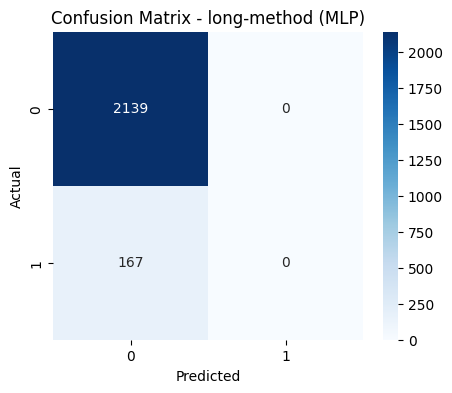

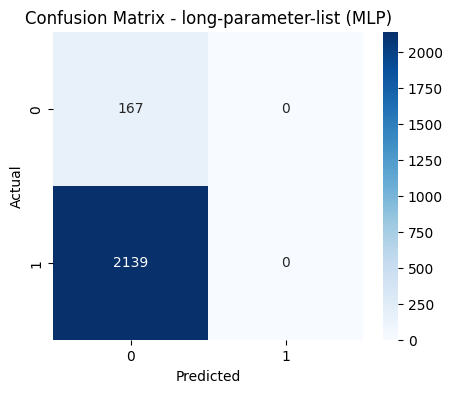

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Model: CNN
Classification Report:
                     precision    recall  f1-score   support

        long-method       0.00      0.00      0.00       167
long-parameter-list       0.00      0.00      0.00      2139

          micro avg       0.00      0.00      0.00      2306
          macro avg       0.00      0.00      0.00      2306
       weighted avg       0.00      0.00      0.00      2306
        samples avg       0.00      0.00      0.00      2306

Acurácia
0.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


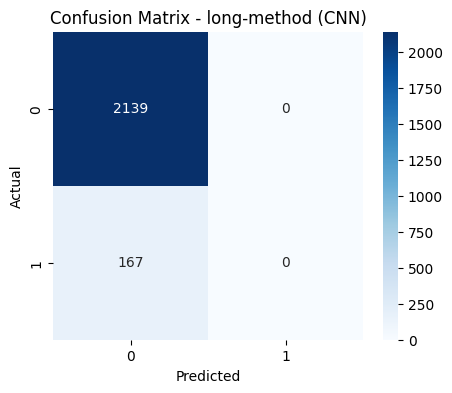

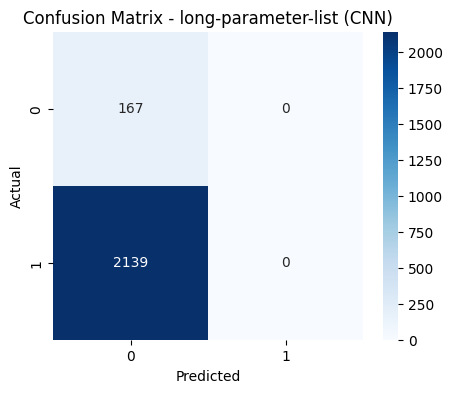

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Model: LSTM
Classification Report:
                     precision    recall  f1-score   support

        long-method       0.00      0.00      0.00       167
long-parameter-list       0.00      0.00      0.00      2139

          micro avg       0.00      0.00      0.00      2306
          macro avg       0.00      0.00      0.00      2306
       weighted avg       0.00      0.00      0.00      2306
        samples avg       0.00      0.00      0.00      2306

Acurácia
0.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


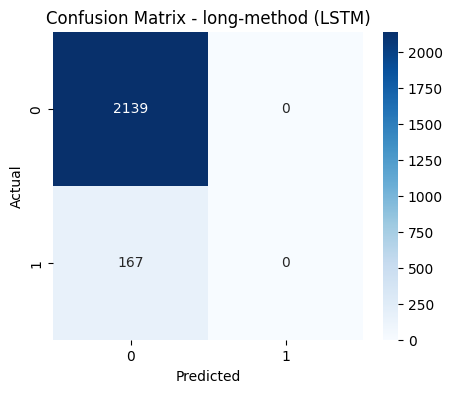

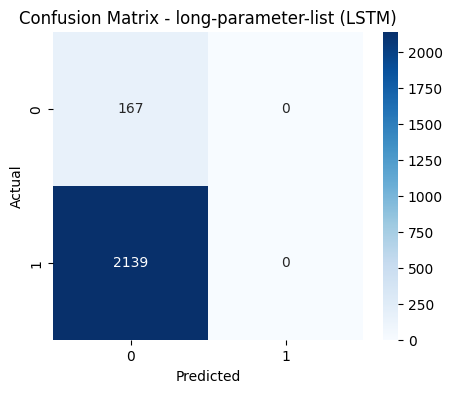

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Model: GRU
Classification Report:
                     precision    recall  f1-score   support

        long-method       0.00      0.00      0.00       167
long-parameter-list       0.00      0.00      0.00      2139

          micro avg       0.00      0.00      0.00      2306
          macro avg       0.00      0.00      0.00      2306
       weighted avg       0.00      0.00      0.00      2306
        samples avg       0.00      0.00      0.00      2306

Acurácia
0.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


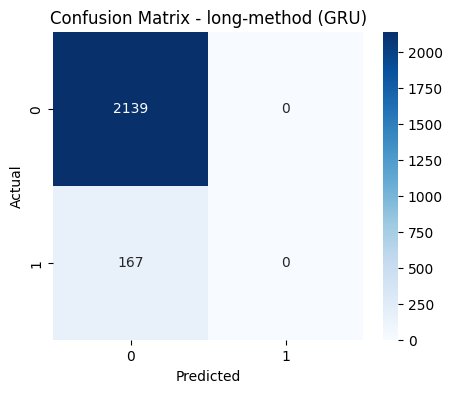

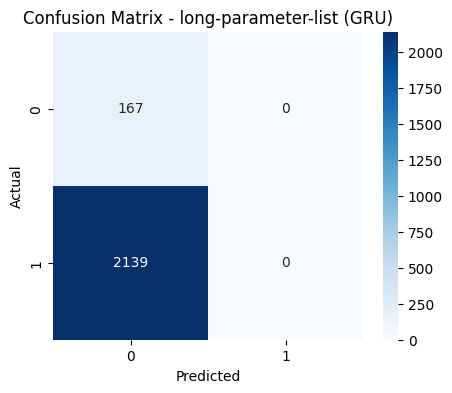

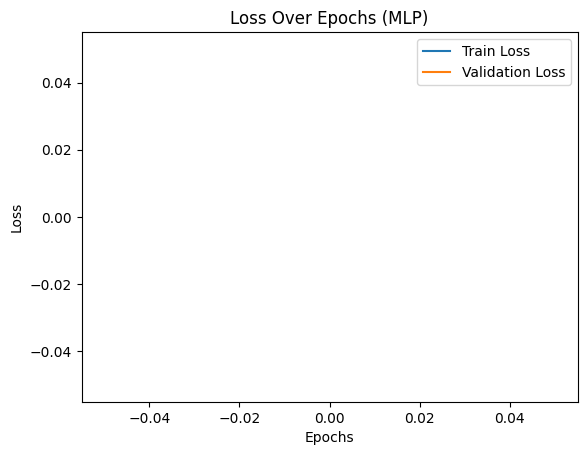

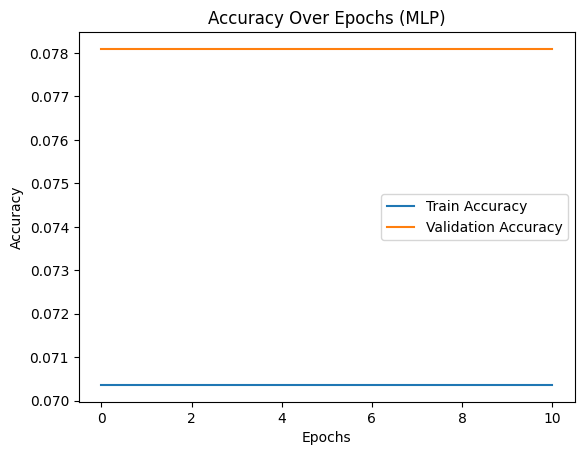

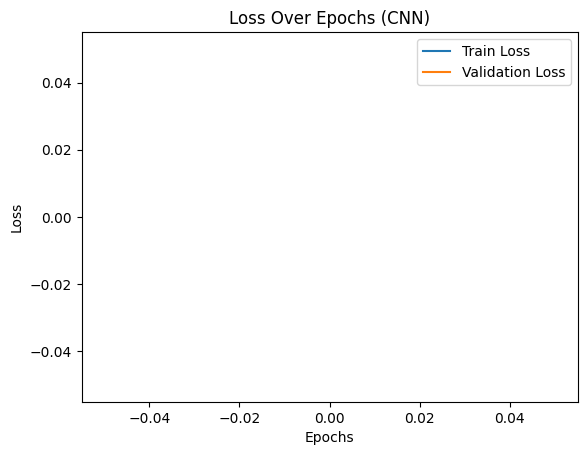

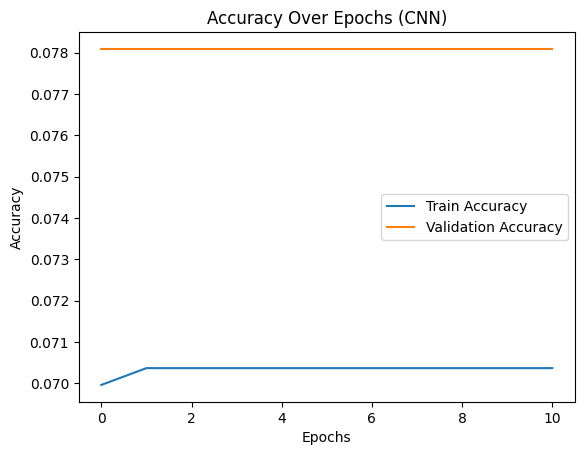

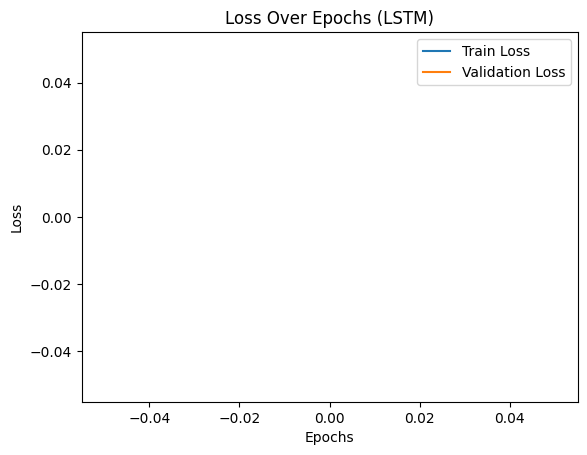

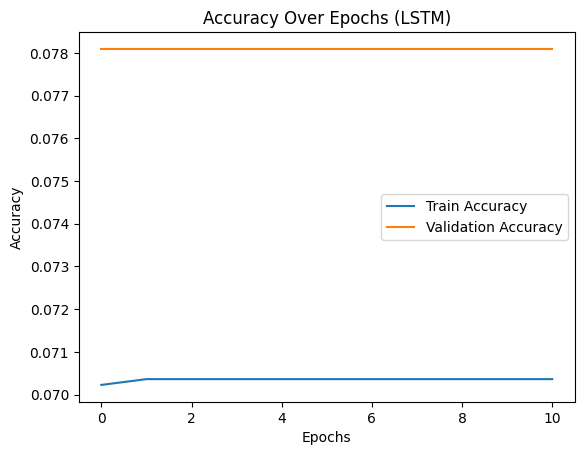

KeyError: 'val_loss'

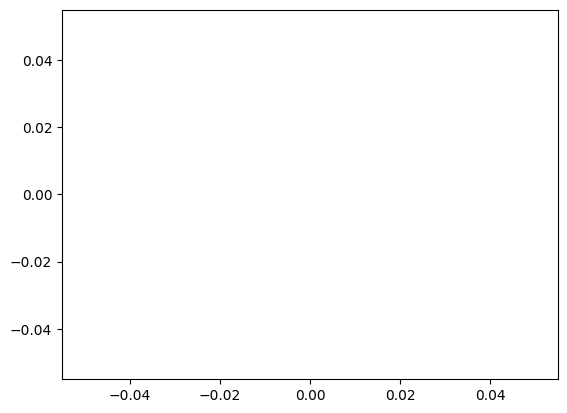

In [ ]:
# Step 6: Evaluate Models
def evaluate_model(model, X_test, y_test, model_name):
    if len(X_test.shape) == 2:  # For MLP
        predictions = model.predict(X_test)
    elif model_name=='CNN' or model_name=='LSTM':  # For CNN and LSTM
        predictions = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
    else:
        predictions = model.predict(X_test)
    predictions = (predictions > 0.5).astype(int)
    print(f"\nModel: {model_name}")
    print("Classification Report:")
    print(classification_report(y_test, predictions, target_names=one_hot_encoder.categories_[0]))
    print("Acurácia")
    print(accuracy_score(y_test, predictions))
    conf_matrix = multilabel_confusion_matrix(y_test, predictions)
    for i, label in enumerate(one_hot_encoder.categories_[0]):
        plt.figure(figsize=(5, 4))
        sns.heatmap(conf_matrix[i], annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {label} ({model_name})')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

# Evaluate all models
evaluate_model(mlp_model, X_test, y_test, "MLP")
evaluate_model(cnn_model, X_test_cnn, y_test, "CNN")
evaluate_model(lstm_model, X_test_cnn, y_test, "LSTM")
evaluate_model(model_gru, X_test_gru, y_test, "GRU")
#evaluate_model(history_capsnet, X_test, y_test, "CapsuleNetworks")

# Step 7: Plot Training History
def plot_history(history, model_name):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(f'Loss Over Epochs ({model_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title(f'Accuracy Over Epochs ({model_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

# Plot histories
plot_history(mlp_history, "MLP")
plot_history(cnn_history, "CNN")
plot_history(lstm_history, "LSTM")
plot_history(history_gru, "GRU")

# Auto Keras

In [5]:
!pip3 install autokeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.7/122.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.7 MB/s eta 0:00:00


In [14]:
import autokeras as ak

# Separando features e alvo
X = df.drop("analyse_type", axis=1)
y = smell

# Codificação de rótulos em inteiros (0, 1, 2...)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Normalização
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Garantir tipo numpy
y_train = np.array(y_train)
y_test = np.array(y_test)

# Criando modelo com AutoKeras
input_node = ak.Input()
output_node = ak.ClassificationHead()
X_train = np.array(X_train).astype("int32")
X_test = np.array(X_test).astype("int32")
y_train = np.array(y_train).astype("int32")
y_test = np.array(y_test).astype("int32")

clf = ak.AutoModel(
    inputs=input_node,
    outputs=output_node,
    overwrite=True,
    max_trials=15
)

# Treinamento
clf.fit(x=X_train, y=y_train, epochs=20, validation_split=0.2, batch_size=8)

# Avaliação
accuracy = clf.evaluate(X_test, y_test)
print(f"Acurácia no conjunto de teste: {accuracy[1]:.4f}")

# Previsão
y_pred = clf.predict(X_test).flatten()

# (Opcional) Decodificando os rótulos previstos
y_pred_labels = label_encoder.inverse_transform(y_pred.astype(int))


Trial 15 Complete [00h 00m 43s]
val_loss: 2.1868071860709631e-13

Best val_loss So Far: 1.239795507451219e-16
Total elapsed time: 00h 10m 50s
Epoch 1/20
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9637 - loss: 3401202.2500
Epoch 2/20
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9989 - loss: 1.8541
Epoch 3/20
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9998 - loss: 6255.0601
Epoch 4/20
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 1.0000 - loss: 5.5943e-04
Epoch 5/20
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 6/20
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9998 - loss: 854.1172
Epoch 7/20
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 1.0000 - loss: 6.5695e-04
Epoch 8/20
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 1.0000 - loss: 3.7157e-04
Epoch 9/20
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 1.0000 - loss: 24.9896
Epoch 10/20
1153/1153 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 2.2153e-15
Acurácia no conjunto de teste: 1.0000
46/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 17))
  warnings.warn(msg)


73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [15]:
y_pred = clf.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Step 10: Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=one_hot_encoder.categories_[0]))

# tuner  AutoModel
tuner = clf.tuner


best_trials = tuner.oracle.get_best_trials(num_trials=10)  # best 10 models

for i, trial in enumerate(best_trials):
    print(f"\nModelo {i+1}:")
    print("Hiperparâmetros:")
    for param, value in trial.hyperparameters.values.items():
        print(f"  {param}: {value}")

    model = tuner.hypermodel.build(trial.hyperparameters)
    print("\nResumo do Modelo:")
    model.summary()


69/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 17))
  warnings.warn(msg)


73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 17))
  warnings.warn(msg)



Classification Report:

                     precision    recall  f1-score   support

        long-method       1.00      1.00      1.00       167
long-parameter-list       1.00      1.00      1.00      2139

           accuracy                           1.00      2306
          macro avg       1.00      1.00      1.00      2306
       weighted avg       1.00      1.00      1.00      2306


Modelo 1:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 3
  general_block_1/dense_block_1/units_0: 64
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 64
  classification_head_1/dropout: 0.5
  optimizer: adam
  learning_rate: 0.001
  general_block_1/dense_block_1/units_2: 32

Resumo do Modelo:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32_1               │ (None, 17)             │             0 │
│ (CastToFloat32)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head_1           │ (None, 1)              │             0 │
│ (Activation)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,665 (6.50 KB)

 Trainable params: 1,665 (6.50 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 2:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 3
  general_block_1/dense_block_1/units_0: 16
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 64
  classification_head_1/dropout: 0.5
  optimizer: adam
  learning_rate: 0.001
  general_block_1/dense_block_1/units_2: 32

Resumo do Modelo:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32_2               │ (None, 17)             │             0 │
│ (CastToFloat32)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head_1           │ (None, 1)              │             0 │
│ (Activation)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,665 (6.50 KB)

 Trainable params: 1,665 (6.50 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 3:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 3
  general_block_1/dense_block_1/units_0: 64
  general_block_1/dense_block_1/dropout: 0.25
  general_block_1/dense_block_1/units_1: 64
  classification_head_1/dropout: 0.5
  optimizer: adam
  learning_rate: 0.001
  general_block_1/dense_block_1/units_2: 32

Resumo do Modelo:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32_3               │ (None, 17)             │             0 │
│ (CastToFloat32)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head_1           │ (None, 1)              │             0 │
│ (Activation)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,665 (6.50 KB)

 Trainable params: 1,665 (6.50 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 4:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: True
  general_block_1/dense_block_1/num_layers: 3
  general_block_1/dense_block_1/units_0: 64
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 64
  classification_head_1/dropout: 0.5
  optimizer: adam
  learning_rate: 0.001
  general_block_1/dense_block_1/units_2: 32

Resumo do Modelo:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32_4               │ (None, 17)             │             0 │
│ (CastToFloat32)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head_1           │ (None, 1)              │             0 │
│ (Activation)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,665 (6.50 KB)

 Trainable params: 1,665 (6.50 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 5:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 3
  general_block_1/dense_block_1/units_0: 64
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 64
  classification_head_1/dropout: 0.5
  optimizer: adam_weight_decay
  learning_rate: 0.001
  general_block_1/dense_block_1/units_2: 32

Resumo do Modelo:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32_5               │ (None, 17)             │             0 │
│ (CastToFloat32)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head_1           │ (None, 1)              │             0 │
│ (Activation)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,665 (6.50 KB)

 Trainable params: 1,665 (6.50 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 6:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 3
  general_block_1/dense_block_1/units_0: 64
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 64
  classification_head_1/dropout: 0.5
  optimizer: adam
  learning_rate: 0.001
  general_block_1/dense_block_1/units_2: 64

Resumo do Modelo:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32_6               │ (None, 17)             │             0 │
│ (CastToFloat32)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head_1           │ (None, 1)              │             0 │
│ (Activation)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,665 (6.50 KB)

 Trainable params: 1,665 (6.50 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 7:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 3
  general_block_1/dense_block_1/units_0: 64
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 64
  classification_head_1/dropout: 0.25
  optimizer: adam
  learning_rate: 0.001
  general_block_1/dense_block_1/units_2: 32

Resumo do Modelo:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32_7               │ (None, 17)             │             0 │
│ (CastToFloat32)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head_1           │ (None, 1)              │             0 │
│ (Activation)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,665 (6.50 KB)

 Trainable params: 1,665 (6.50 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 8:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 3
  general_block_1/dense_block_1/units_0: 64
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 32
  classification_head_1/dropout: 0.25
  optimizer: adam
  learning_rate: 0.001
  general_block_1/dense_block_1/units_2: 32

Resumo do Modelo:


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32_8               │ (None, 17)             │             0 │
│ (CastToFloat32)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_17 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_18 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head_1           │ (None, 1)              │             0 │
│ (Activation)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,665 (6.50 KB)

 Trainable params: 1,665 (6.50 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 9:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 2
  general_block_1/dense_block_1/units_0: 64
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 64
  classification_head_1/dropout: 0.5
  optimizer: adam
  learning_rate: 0.001
  general_block_1/dense_block_1/units_2: 32

Resumo do Modelo:


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32_9               │ (None, 17)             │             0 │
│ (CastToFloat32)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_19 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_20 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head_1           │ (None, 1)              │             0 │
│ (Activation)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,665 (6.50 KB)

 Trainable params: 1,665 (6.50 KB)

 Non-trainable params: 0 (0.00 B)


Modelo 10:
Hiperparâmetros:
  general_block_1/dense_block_1/use_batchnorm: False
  general_block_1/dense_block_1/num_layers: 2
  general_block_1/dense_block_1/units_0: 64
  general_block_1/dense_block_1/dropout: 0.0
  general_block_1/dense_block_1/units_1: 32
  classification_head_1/dropout: 0.25
  optimizer: adam
  learning_rate: 0.001

Resumo do Modelo:


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32_10              │ (None, 17)             │             0 │
│ (CastToFloat32)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_21 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_22 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head_1           │ (None, 1)              │             0 │
│ (Activation)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,665 (6.50 KB)

 Trainable params: 1,665 (6.50 KB)

 Non-trainable params: 0 (0.00 B)